# Baseline Model
The baseline model is intended to give "predictions" on a simple assumption. In this case; we are trying to predict the points scored by a team based on their average points scored in the **last N games**.

- Data is fetched and rearranged as samples of sequences of scored points.
- Predictions are created by the baseline model.
- Evaluation is done using MAE and R-Squared

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from nba_analysis import NBAPlayer, NBATeam, NBAGame
from nba_analysis.models import BaselineModel

Using TensorFlow backend.


### Getting data
##### Mainly; Teams, Players, and Matches of the Current Season.

In [2]:
teams = NBATeam.get_teams_list()
players = NBAPlayer.get_players_list(is_active=True)
all_matches = {
    k: team.get_last_matches() for k, team in tqdm(teams.items(), "Teams", len(teams))
}

Teams: 100%|██████████| 30/30 [01:15<00:00,  2.53s/it]


### Creating baseline models
- Each baseline model corresponds to a different sequence length (1 -> 19).
- Each model is evaluated with Mean Absolute Error (MAE) and R-Squared.

In [3]:
from sklearn.metrics import r2_score

mae = []
r2 = []
for match_seqlen in tqdm(range(1, 20)):
    x = []
    y_true = []
    for k, matches in all_matches.items():
        for i in range(1, len(matches) - match_seqlen):
            x.append(matches.iloc[i : i + match_seqlen][["PTS"]].values)
            y_true.append(matches.iloc[i - 1, -1])

    x = np.squeeze(np.asanyarray(x), axis=-1)
    baseline = BaselineModel(match_seqlen)
    y_pred = baseline.predict(x)
    mae.append(baseline.score(y_true, y_pred))
    r2.append(baseline.score(y_true, y_pred, r2_score))
mae = np.asanyarray(mae)
r2 = np.asanyarray(r2)

100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


### Plotting performance

#### MAE Curve

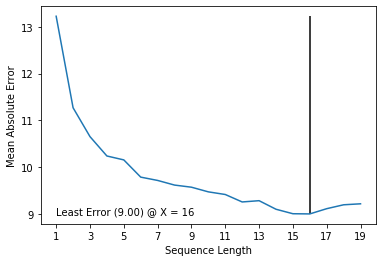

In [4]:
ax = sns.lineplot(range(1, 20), mae)
_ = ax.set_xlabel("Sequence Length")
_ = ax.set_ylabel("Mean Absolute Error")
_ = ax.set_xticks(range(1, 20, 2))
_ = ax.vlines(mae.argmin() + 1, min(mae), max(mae))
_ = ax.text(1, mae.min(), f"Least Error ({mae.min():.2f}) @ X = {mae.argmin()+1}")

#### R2 Curve

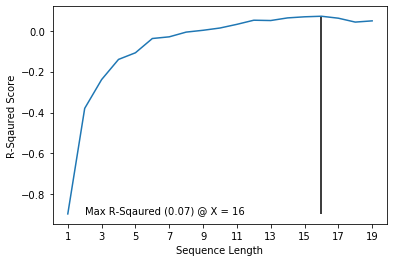

In [5]:
ax = sns.lineplot(range(1, 20), r2)
_ = ax.set_xlabel("Sequence Length")
_ = ax.set_ylabel("R-Sqaured Score")
_ = ax.set_xticks(range(1, 20, 2))
_ = ax.vlines(r2.argmax() + 1, min(r2), max(r2))
_ = ax.text(2, r2.min(), f"Max R-Sqaured ({r2.max():.2f}) @ X = {r2.argmax()+1}")

### Conclusion:
* Baseline model performs better with a sequence of 15 matches.
* Best MAE score is 9.39, which means that the model is off by 9 points on average at its best.
* Best R-Squared score is 0.07, which means that the model can explain 7% of the varition in the data.